In [807]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

Data Loading, understanding,cleaning and handlining missing values..

In [808]:
dataset=pd.read_csv("IMDb_Movies_India.csv", encoding="latin-1")
dataset.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [809]:
dataset.shape #show number of rows and columns

(15509, 10)

In [810]:
dataset.info()    #gives information about dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [811]:
dataset.isnull().sum()    #shown count of null values in different columns

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [813]:
#dropping rows with null values of rating as it conatains around 50% of null values
dataset = dataset.dropna(subset=['Rating'])


In [812]:
#extracting Numeric data from duration
dataset['Duration'] = dataset['Duration'].str.extract('(\d+)')
dataset['Duration'] = dataset['Duration'].astype(float)


In [814]:
dataset.describe()    #descirbe numberic data from dataset

,Duration,Rating
count,5851.000000,7919.000000
mean,132.294480,5.841621
std,26.555826,1.381777
min,21.000000,1.100000
25%,117.000000,4.900000
50%,134.000000,6.000000
75%,150.000000,6.800000
max,321.000000,10.000000


In [815]:
#filling dataset Duration with median to prevent from effect of outliers 
dataset['Duration'].fillna(dataset['Duration'].median(), inplace=True)   

In [816]:
#filling genre and Direction with value Unknown
dataset['Genre'].fillna('Unknown', inplace=True)
dataset['Director'].fillna('Unknown',inplace=True)

In [817]:
#filling null actor with unknown
dataset[['Actor 1', 'Actor 2', 'Actor 3']] = (
    dataset[['Actor 1', 'Actor 2', 'Actor 3']]
    .fillna('Unknown')
)


In [818]:
dataset.isnull().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

Visualization

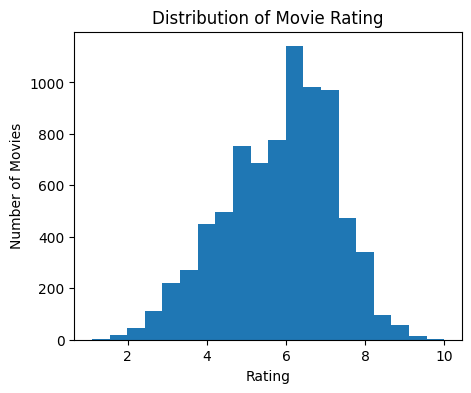

In [819]:
#Showing Distribution of Movies
plt.figure(figsize=(5,4))
plt.hist(x=dataset['Rating'],bins=20)
plt.xlabel("Rating")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movie Rating")
plt.show()

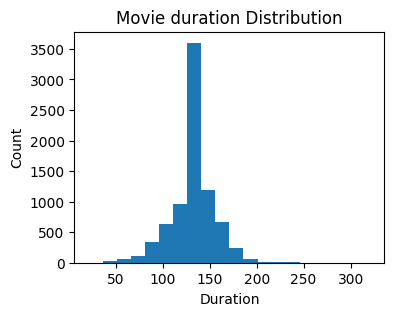

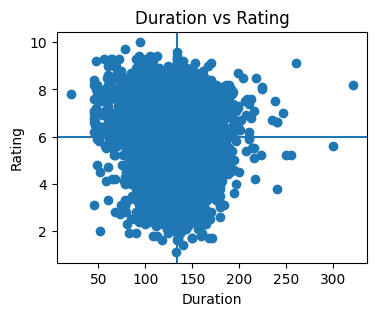

In [820]:
#Duration Analysis
mean_Duration = dataset['Duration'].median()
median_rating = dataset['Rating'].median()

plt.figure(figsize=(4,3))
plt.hist(x=dataset['Duration'],bins=20)
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Movie duration Distribution')
plt.show()

plt.figure(figsize=(4,3))
plt.scatter(dataset['Duration'], dataset['Rating'])
plt.axvline(mean_Duration)
plt.axhline(median_rating)
plt.xlabel("Duration")
plt.ylabel("Rating")
plt.title("Duration vs Rating")
plt.show()


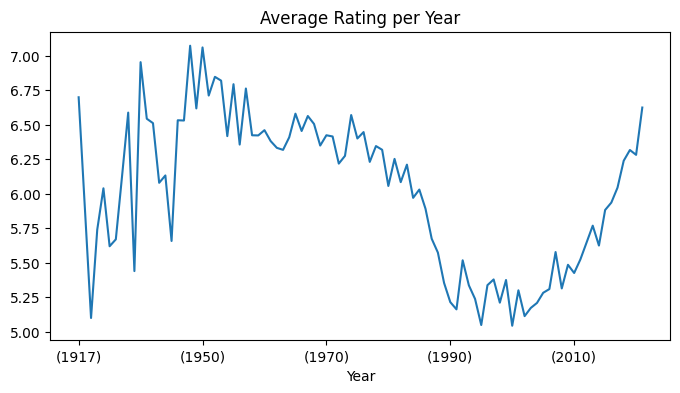

In [821]:
#Avgrating per Year Wise
plt.figure(figsize=(8,4))
dataset.groupby('Year')['Rating'].mean().plot()
plt.title("Average Rating per Year")
plt.show()

In [822]:
#Name column is not required to train the model to dropping
dataset.drop(columns=['Name'],inplace=True)

Handling High-Cardinality Categorical Features [Target (mean) Encoding is Used]

In [823]:
#Encode Year
dataset['Year_Avg_Rating']=dataset.groupby('Year')['Rating'].transform('mean')
dataset.drop(columns=['Year'],inplace=True)

In [824]:
#Encode Votes and also convert votes to numeric format at first
dataset['Votes'] = pd.to_numeric(dataset['Votes'], errors='coerce')
dataset['Vote_bin']=pd.qcut(dataset['Votes'],q=5, duplicates='drop')
dataset['Votes_Avg_Rating']=dataset.groupby('Vote_bin')['Rating'].transform('mean')
dataset.drop(columns=['Votes','Vote_bin'], inplace=True)

In [825]:
# Encode Genre
dataset['Genre_Avg_Rating']=dataset.groupby('Genre')['Rating'].transform('mean')
dataset.drop(columns=['Genre'],inplace=True)

In [826]:
# Encode Director 
dataset['Director_Avg_Rating']=dataset.groupby('Director')['Rating'].transform('mean')
dataset.drop(columns=['Director'],inplace=True)

In [827]:
# Encode Actors 
dataset['Actor1_Avg_Rating']=dataset.groupby('Actor 1')['Rating'].transform('mean')
dataset['Actor2_Avg_Rating']=dataset.groupby('Actor 2')['Rating'].transform('mean')
dataset['Actor3_Avg_Rating']=dataset.groupby('Actor 3')['Rating'].transform('mean')
dataset.drop(columns=['Actor 1','Actor 2','Actor 3'],inplace=True)

In [828]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7919 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Duration             7919 non-null   float64
 1   Rating               7919 non-null   float64
 2   Year_Avg_Rating      7919 non-null   float64
 3   Votes_Avg_Rating     6548 non-null   float64
 4   Genre_Avg_Rating     7919 non-null   float64
 5   Director_Avg_Rating  7919 non-null   float64
 6   Actor1_Avg_Rating    7919 non-null   float64
 7   Actor2_Avg_Rating    7919 non-null   float64
 8   Actor3_Avg_Rating    7919 non-null   float64
dtypes: float64(9)
memory usage: 618.7 KB


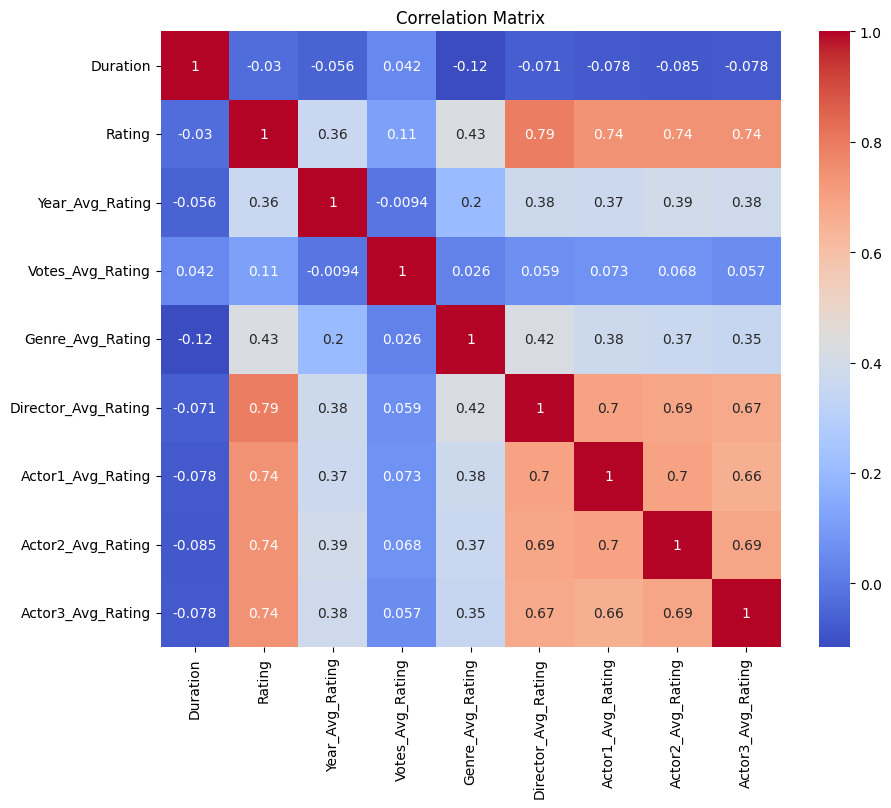

In [829]:
#show Correlation 
plt.figure(figsize=(10,8))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Feature Scaling

In [830]:
# split again after clipping
X = dataset.drop('Rating', axis=1)
y = dataset['Rating']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Model Training

In [831]:
imputer = SimpleImputer(strategy='median')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)


In [832]:
#linear Regression
lr=LinearRegression()
lr.fit(x_train,y_train)
lr_pred=lr.predict(x_test)

In [833]:
#Random Forest Regressor
rf=RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train,y_train)
rf_pred=rf.predict(x_test)

In [834]:
# Generating Boosting Regressor
gb=GradientBoostingRegressor(random_state=42)
gb.fit(x_train,y_train)
gb_pred=gb.predict(x_test)

Model Evaluation

In [835]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Gradient Boosting"],
    "R2 Score": [
        r2_score(y_test, lr_pred),
        r2_score(y_test, rf_pred),
        r2_score(y_test, gb_pred)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, lr_pred)),
        np.sqrt(mean_squared_error(y_test, rf_pred)),
        np.sqrt(mean_squared_error(y_test, gb_pred))
    ],
    "MAE ":[
        mean_absolute_error(y_test, lr_pred),
        mean_absolute_error(y_test, rf_pred),
        mean_absolute_error(y_test, gb_pred)
    ]

})

print(results)


               Model  R2 Score      RMSE      MAE 
0  Linear Regression  0.758425  0.670167  0.490771
1      Random Forest  0.778255  0.642072  0.430074
2  Gradient Boosting  0.775577  0.645937  0.459772


In [ ]:
# Cross-validation for R²
r2_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Random Forest CV R² mean:", round(r2_scores.mean(), 3))

# Cross-validation for RMSE
rmse_scores = np.sqrt(-cross_val_score(rf, X, y, cv=5, scoring='neg_mean_squared_error'))
print("Random Forest CV RMSE mean:", round(rmse_scores.mean(), 3))

Random Forest CV R² mean: 0.785
Random Forest CV RMSE mean: 0.64


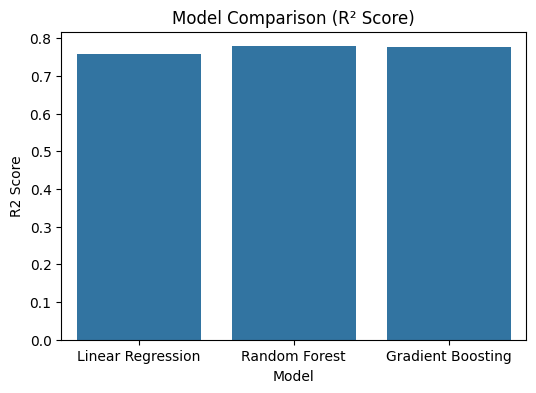

In [837]:
plt.figure(figsize=(6,4))
sns.barplot(x="Model", y="R2 Score", data=results)
plt.title("Model Comparison (R² Score)")
plt.show()


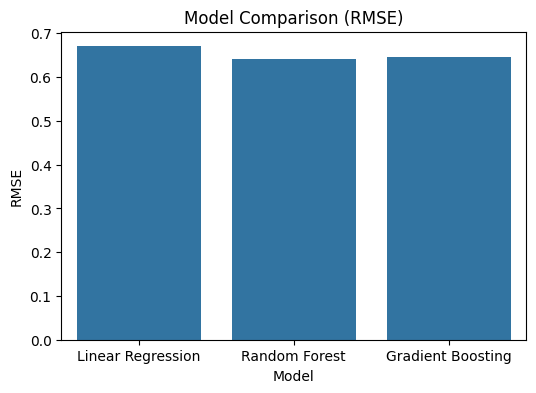

In [838]:
plt.figure(figsize=(6,4))
sns.barplot(x="Model", y="RMSE", data=results)
plt.title("Model Comparison (RMSE)")
plt.show()


In [839]:
best_model_name = results.sort_values("R2 Score", ascending=False).iloc[0]["Model"]
print("Best Model:", best_model_name)


Best Model: Random Forest


In [845]:
best_model = None
if best_model_name == "Random Forest":
    best_model = rf
elif best_model_name == "Gradient Boosting":
    best_model = gb
else:
    best_model = lr
print(best_model)

RandomForestRegressor(random_state=42)


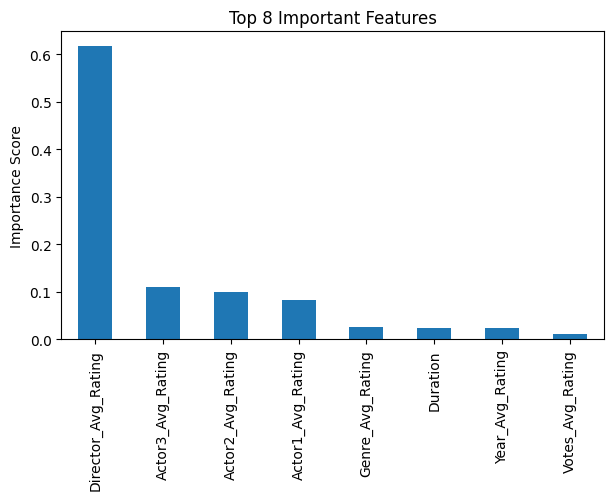

In [846]:
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(7,4))
feature_importance.head(8).plot(kind='bar')
plt.title("Top 8 Important Features")
plt.ylabel("Importance Score")
plt.show()


In [847]:
#Example
new_movie = pd.DataFrame({
    "Duration": [120],
    "Year_Avg_Rating": [6.8],
    "Votes_Avg_Rating": [7.0],
    "Genre_Avg_Rating": [6.5],
    "Director_Avg_Rating": [7.2],
    "Actor1_Avg_Rating": [6.9],
    "Actor2_Avg_Rating": [6.7],
    "Actor3_Avg_Rating": [6.8]
})

new_movie = imputer.transform(new_movie)
prediction = best_model.predict(new_movie)

print("Predicted Movie Rating:", round(prediction[0], 2))


Predicted Movie Rating: 7.19
